# Calculation of different ML methods for prediction of Pulmonary hypertension (PH)

* Random forests
* XGBoost

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
import xgboost as xgb
import random
seed = 123
random.seed = seed
np.random.seed(seed)
POSITIVE_LABEL = 'PH'
NEGATIVE_LABEL = 'HC DC'
SELECTED_COL = 'Recurrent_ID'

In [18]:
filename = 'Bordag_et_al_2023_FFAlipid_biomarker_PH_Supplementary_data_1.xlsx'
df_train_driftcorr = pd.read_excel(filename, sheet_name = "train_Ravg_LOG_driftcorr")
df_val_driftcorr = pd.read_excel(filename, sheet_name = "val_Ravg_LOG_driftcorr")
df_train = pd.read_excel(filename, sheet_name = "train_Ravg_LOG")
df_val = pd.read_excel(filename, sheet_name = "val_Ravg_LOG")
df_train_70 = pd.read_excel(filename, sheet_name="train70_Ravg_LOG")
df_val_30 = pd.read_excel(filename, sheet_name="val30_Ravg_LOG")

## Functions

In [19]:
# impute features with KNNImputer
def get_imputed_dataset(df_train, df_val, col_imp):
    imputed_columns = {}
    df_train_new = df_train[col_imp].copy()
    df_val_new = df_val[col_imp].copy()
    df = pd.concat([df_train_new, df_val_new], ignore_index = True)

    # all columns with nan
    col_nan = df.isna().any()

    for c in col_nan.index:
        # imputation
        if col_nan[c]:
            # check if more than 30% missing
            if df_train[c].isna().sum() < len(df_train[c])*0.3:  
                imputed_columns[c] = df_train[c].isna().sum()         
                imputer = KNNImputer(n_neighbors = 2, weights = "uniform")
                new_c_train = imputer.fit(np.array(df_train[c]).reshape(-1, 1) )
                new_c_val = imputer.transform(np.array(df_val[c]).reshape(-1, 1) )
                new_c_train = imputer.transform(np.array(df_train[c]).reshape(-1, 1) )
                df_val_new.loc[:, c] = new_c_val
                df_train_new.loc[:, c] = new_c_train

    return df_train_new, df_val_new, imputed_columns

# normalize data
def normalize(data, columns = []):
    data_normalized = {}
    dn_list = []
    #print('n data columns',len(data.columns))
    #print(data.columns)
    for c in data.columns:
        if (data[c] == data[c]).all():
            if c == 'sex':
                c_new = data[c] == 'female'
            else:
                c_new = (data[c].values - min(data[c].values))/(max(data[c].values) - min(data[c].values))
            if columns:
                if c in columns:
                    dn_list.append(list(c_new))
                    data_normalized[c]  = c_new
            else:
                dn_list.append(list(c_new))
                data_normalized[c]  = c_new
        else:
            print('Nans in column:', c)
    return data_normalized, dn_list

def flat(list):
    return [item for subl in list for item in subl]

def get_Xy(data):
    data_d = data.drop(columns=[SELECTED_COL, 'class', 'age', 'sex', 'BMI'])
    _, X = normalize(data_d)
    X = np.asarray(X).T
    y = data['class'] == POSITIVE_LABEL
    return X, y

def calc_model(modelname, hyper_parameter):
    # random forest
    if modelname == 'rf':
        no_trees = hyper_parameter[0]
        depth = hyper_parameter[1]
        model = RandomForestClassifier(max_depth = depth, random_state = seed, n_estimators = no_trees)
    # extreme gradient boosting
    elif modelname == 'xg':
        learning_rate = hyper_parameter[0]
        max_depth = hyper_parameter[1]
        n_estimators = hyper_parameter[2]
        model = xgb.XGBClassifier(objective  = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = learning_rate, 
                max_depth = max_depth, alpha = 10, n_estimators = n_estimators, random_state = seed)
    return model

def get_hyperparameter(hyp_param, modelname):
    if hyp_param:
        return hyp_param
    else:
        if modelname == 'rf':
            # no of trees and depth
            return [[1001, 5]]
        elif modelname == 'xg':
            # eta and max depth and n_estimators
            return [[0.1, 5, 10]]

def get_age_level(age_col, level):
    level_split = (max(age_col) - min(age_col))/level
    age_level = []
    
    for a in age_col:
        threshold = min(age_col)
        level_count = 0
        while a >= threshold:
            threshold   += level_split
            level_count   += 1
        age_level.append(level_count)

    return age_level

def get_random_split(data, selected_col, split_no = 5):
    split_ids = []
    split_indices = []
    at_least = 1
    ## age
    data['age_level'] = get_age_level(data['age'], 5)
    df_drop = data.copy()
    for split in range(split_no, 0, -1):
        test_proportion = 1/split
        # grouping by gender, label and age
        grps = df_drop.groupby(['sex', 'class', 'age_level'], group_keys = False)
        # selection by test_proportion and grouping
        test = grps.apply(lambda x: x.sample(max(round(len(x)*test_proportion), at_least), random_state = seed))
        split_ids.extend(test.index)
        split_indices.append(test[selected_col])
        df_drop = data.copy()
        df_drop.drop(split_ids, inplace = True)

    return split_indices

def test_model(train_set, val_set, col, modelname, drift, hyper_param = [], title = 'Metabolites'):
    data = train_set
    
    print('Results for ' + modelname + ' and ' + drift + ' for all ' + title)

    selected_col = SELECTED_COL

    threshold_cm = 0.5
    tprs_val = []
    fprs_val = []
    aucs_val = []
    tprs_test = []
    fprs_test = []
    aucs_test = []
    cm_test = []
    fi = []
    feature_importances = pd.DataFrame()
    interp_mean_fpr = np.linspace(0, 1, 100)
    cm_val = []
    y_hat_vals = []
    y_vals = []
    # parameters for AUROC
    linesize = 0.25
    w_ROC = 5.0
    h_ROC = 5.0

    col_train, col_val = get_color(modelname)
    
    # set hyperparameter
    hyp = get_hyperparameter(hyper_param, modelname)
    split = get_random_split(data.copy(), selected_col)

    data = data[col]
    val_set = val_set[col]
    
    # plotting
    plt.rcParams['axes.linewidth'] = linesize
    fig, ax = plt.subplots(1, figsize = (w_ROC, h_ROC))
    # make grid in the background
    ax.set_axisbelow(True)
    ax.grid(which = 'major', linestyle = 'dashed', color = '#E6E6E6', dashes = (8, 8))
    i = 1
    feature_importance_df = pd.DataFrame({'Features': data.columns[5:len(train_set.columns)]})
    # cross validation over all splits
    for s in split:
        # get train and test split
        test_set = data[data[selected_col].isin(s)].copy()
        train_set = data[data[selected_col].isin(list(set(flat(split)) - set(s)))].copy()


        X_train, y_train = get_Xy(train_set)
        X_test, y_test = get_Xy(test_set)
        X_val, y_val = get_Xy(val_set) 

        #print('features x_train: ',len(X_train[0]))
        
        # train the model
        model = calc_model(modelname, hyp)
        model.fit(X_train, y_train)

        # test the model
        #print('features x_test: ',len(X_test[0]))
        y_hat_test = model.predict_proba(X_test) 
        feature_importance_df[f'Importance_{i}'] = model.feature_importances_
        i+=1
        #fi.append(feature_importance_df)

        fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_hat_test[:, 1]) 
        auc_test = roc_auc_score(y_test, y_hat_test[:, 1]) 

        # Interpolation
        interp_tpr = np.interp(interp_mean_fpr, fpr_test, tpr_test)
        interp_tpr[0] = 0.0
        tpr_test = interp_tpr
        fpr_test = interp_mean_fpr
        conf_m_test = confusion_matrix(y_test, y_hat_test[:, 1]>threshold_cm)
 
        tprs_test.append(tpr_test)
        fprs_test.append(fpr_test)
        aucs_test.append(auc_test)
        cm_test.append(conf_m_test)

        # validation
        y_hat_val = model.predict_proba(X_val) 
        y_hat_vals.append(y_hat_val[:, 1])
        y_vals.append(y_val)
        fpr_val, tpr_val, threshold = roc_curve(y_val, y_hat_val[:, 1]) 
        auc_val = roc_auc_score(y_val, y_hat_val[:, 1]) 
        conf_m_val = confusion_matrix(y_val, y_hat_val[:, 1]>threshold_cm)

        # Interpolation of tpr and fpr for AUC
        interp_tpr_val = np.interp(interp_mean_fpr, fpr_val, tpr_val)
        interp_tpr_val[0] = 0.0
        tpr_val = interp_tpr_val
        fpr_val = interp_mean_fpr

        tprs_val.append(tpr_val)
        fprs_val.append(fpr_val)
        aucs_val.append(auc_val)
        cm_val.append(conf_m_val)

    mean_tpr = np.mean(tprs_test, axis = 0)
    ax.plot([0, 1], [0, 1], lw = 2, color = "#D2D2D2", alpha = 0.6)
    mean_tpr[-1] = 1.0
    mean_auc = auc(interp_mean_fpr, mean_tpr)
    
    #################################################
    # plot train
    ax.plot(
        interp_mean_fpr, 
        mean_tpr, 
        color = col_train, 
        lw = 2, 
        alpha = 0.8, 
    )
    # calculate 95% CI for plot
    std_tpr_test = np.std(tprs_test, axis = 0)
    tprs_upper_test = np.minimum(mean_tpr + 0.95*std_tpr_test, 1)
    tprs_lower_test = np.maximum(mean_tpr - 0.95*std_tpr_test, 0)

    ax.fill_between(
        interp_mean_fpr, 
        tprs_lower_test, 
        tprs_upper_test, 
        color = col_train, 
        alpha = 0.2, 
    )

    #######################################################
    # plot  validation
 
    mean_tpr_val = np.mean(tprs_val, axis = 0)
    mean_tpr_val[-1] = 1.0
    mean_auc_val = auc(interp_mean_fpr, mean_tpr_val)

    ax.plot(
        interp_mean_fpr, 
        mean_tpr_val, 
        color = col_val, 
        linestyle = 'dashed', 
        lw = 2, 
        alpha = 0.8, 
    )
    
    # Calculate 95% CI
    std_tpr_val = np.std(tprs_val, axis = 0)
    tprs_upper_val = np.minimum(mean_tpr_val + 0.95*std_tpr_val, 1)
    tprs_lower_val = np.maximum(mean_tpr_val - 0.95*std_tpr_val, 0)
    
    ax.fill_between(
        interp_mean_fpr, 
        tprs_lower_val, 
        tprs_upper_val, 
        color = col_val, 
        alpha = 0.2, 
    )
    ##################################################

    ax.set(
        xlim = [ - 0.05, 1.05], 
        ylim = [ - 0.05, 1.05], 
    )

    ax.text(0.95, 0.08, r"train AUC %0.2f" % (mean_auc), horizontalalignment = 'right')
    ax.text(0.95, 0, r"val AUC %0.2f" % (mean_auc_val), horizontalalignment = 'right')
    
    #fig.set_dpi(600)

    # statistics
    model_type = modelname + drift + title
    df_save = pd.DataFrame(index = [model_type])
    # info about dataset:

    sp, se, acc, bacc, df_save = get_statistical_values(cm_test, df_save, model_type, prefix = 'test')
    print('Train Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ', acc, ' Balanced Accuracy: ', bacc)
    sp, se, acc, bacc, df_save = get_statistical_values(cm_val, df_save, model_type, prefix = 'val')
    print('Validation Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ', acc, ' Balanced Accuracy: ', bacc)
    sp, se, acc, bacc, df_save = get_statistical_values(cm_test + cm_val, df_save, model_type, prefix = 'joint')
    print('Joint Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ', acc, ' Balanced Accuracy: ', bacc)
    df = pd.DataFrame(data = {'# of features':[len(data.columns)],'# of samples in trainset':[len(data)],'# of samples in valset':[len(val_set)],'test_AUC':[mean_auc], 'val_AUC':[mean_auc_val], 'joint_AUC':[(mean_auc_val + mean_auc)/2]}, index = [model_type])
    df_save = df_save.join(df)       
 
    return df_save, feature_importance_df

def get_color(modelname):
    if modelname == 'rf':
        return 'green', "#0EF047"
    elif modelname == 'xg':
        return '#0000ff', '#74AFF7'

# Confusionmatrix
# TP FN
# FP TN
# sensitivity tpr = TP/P
# specificity tnr = TN/N
# accuracy = (tp + tn)/(p + n)
# balanced accuracy = (tpr + tnr)/2
def get_statistical_values(cm_list, df_save, model_type, prefix = ''):
    if prefix != '': prefix = prefix + '_'
    cm = np.mean(cm_list, axis = 0)
    sensitivity = cm[0, 0]/(cm[0, 0] + cm[1, 0])
    specificity = cm[1, 1]/(cm[1, 1] + cm[0, 1])
    accuracy = (cm[1, 1] + cm[0, 0])/(cm[1, 0] + cm[0, 1] + cm[1, 1] + cm[0, 0])
    bacc = (sensitivity + specificity)/2

    df = pd.DataFrame(data = {prefix + 'Sensitivity':[sensitivity], prefix + 'Specificity':[specificity], prefix + 'Accuracy':[accuracy], prefix + 'BACC':[bacc]}, index = [model_type])
    df_save = df_save.join(df)

    return specificity, sensitivity, accuracy, bacc, df_save

# All metabolite columns for data that was drift corrected (OEME) and not drift corrected (OE)
# add_col ... additional columns to metabolites
def get_columns(df_drifcorr, df_drift, add_col):
    col1 = df_drifcorr.columns[df_drifcorr.columns.str.contains('Metab_MVA_UVA.')]
    col2 = col1[col1.str.contains('\.LOG_QCRFSC_Peakarea_OEME')]
    col_OEME = add_col + list(col2)
    col3 = df_drift.columns[df_drift.columns.str.contains('Metab_MVA_UVA.')]
    col4 = col3[col3.str.contains('\.LOG_Peakarea_OE')]
    col_OE = add_col + list(col4)
    return col_OEME, col_OE


In [20]:
# for saving data in file
df_results = pd.DataFrame()

# Constants
no_drift = '(data without drift correction)'
# additional columns to metabolites
add_col = [SELECTED_COL, 'class', 'age', 'sex', 'BMI']

# columns
col_OEME, col_OE = get_columns(df_train_driftcorr, df_train, add_col)

### Imputation

In [21]:
df_train_driftcorr_new, df_val_driftcorr_new, df_driftcorr_imp_col = get_imputed_dataset(df_train_driftcorr, df_val_driftcorr, col_OEME)
df_train_new, df_val_new, df_driftcorr_imp_col = get_imputed_dataset(df_train, df_val, col_OE)
df_train_new_70, df_val_new_30, df_driftcorr_imp_col = get_imputed_dataset(df_train_70,df_val_30, col_OE)

# len of datasets
print('len split by center trainset: ',len(df_train_driftcorr_new))
print('len split by center valset: ',len(df_val_driftcorr_new))
print('len trainset 70%: ',len(df_train_new_70))
print('len valset 30%: ',len(df_val_new_30))
# of features:
print('feature len split by center trainset: ',len(df_train_driftcorr_new.columns))
print('feature len trainset 70%: ',len(df_train_new_70.columns))

len split by center trainset:  169
len split by center valset:  64
len trainset 70%:  163
len valset 30%:  70
feature len split by center trainset:  158
feature len trainset 70%:  158


## Calculations and Results(ML Part)

### calculate random forest with data that was not drift corrected

In [22]:
modelname = 'rf'
drift = 'drift correction'
hyper_param = [3001, 300]

All metabolites:  153
Results for rf and drift correction for all center split 
Train Sensitivity:  0.9404761904761905  Specificity:  0.8117647058823529  Accuracy:  0.8757396449704143  Balanced Accuracy:  0.8761204481792717
Validation Sensitivity:  0.2165605095541401  Specificity:  0.9938650306748466  Accuracy:  0.6124999999999999  Balanced Accuracy:  0.6052127701144934
Joint Sensitivity:  0.46887966804979253  Specificity:  0.9314516129032259  Accuracy:  0.703476482617587  Balanced Accuracy:  0.7001656404765092


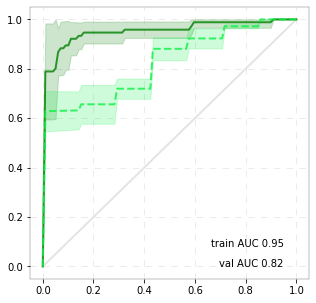

In [23]:
# split by center
print('All metabolites: ', len(col_OEME)-5)
df_save, fi = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_OEME, title = 'center split ', modelname = modelname, drift = drift, hyper_param = hyper_param)
df_results = pd.concat([df_results, df_save])

### calculate random forest with not drift corrected data

In [24]:
drift = 'drift'

Results for rf and drift for all center split (data without drift correction)


Train Sensitivity:  0.9459459459459459  Specificity:  0.7368421052631579  Accuracy:  0.8284023668639054  Balanced Accuracy:  0.8413940256045519
Validation Sensitivity:  0.24038461538461536  Specificity:  0.9537037037037037  Accuracy:  0.721875  Balanced Accuracy:  0.5970441595441596
Joint Sensitivity:  0.5337078651685393  Specificity:  0.887459807073955  Accuracy:  0.7586912065439673  Balanced Accuracy:  0.7105838361212471


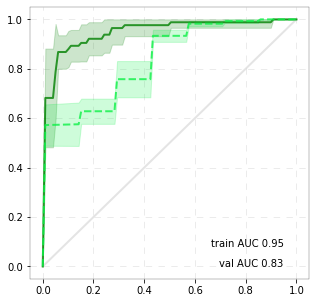

In [25]:
# split by center
df_save, _ = test_model(df_train_new, df_val_new, col_OE, title = 'center split '+ no_drift, modelname = modelname, drift = drift, hyper_param = hyper_param)
df_results = pd.concat([df_results, df_save])

Results for rf and drift for all 70:30 split (data without drift correction)


Train Sensitivity:  0.8666666666666667  Specificity:  0.8252427184466019  Accuracy:  0.8404907975460122  Balanced Accuracy:  0.8459546925566344
Validation Sensitivity:  0.8133333333333332  Specificity:  0.8099999999999999  Accuracy:  0.8114285714285714  Balanced Accuracy:  0.8116666666666665
Joint Sensitivity:  0.8285714285714285  Specificity:  0.8151815181518153  Accuracy:  0.820662768031189  Balanced Accuracy:  0.821876473361622


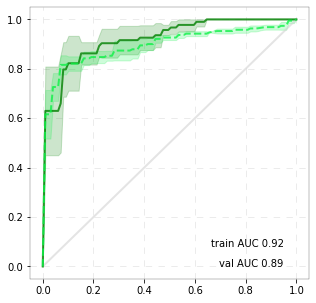

In [26]:
# 70:30 split
df_save, _ = test_model(df_train_new_70, df_val_new_30, col_OE, title='70:30 split '+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

### calculate XGB with drift corrected data

In [27]:
hyper_param = [0.01, 10, 3001]
modelname = 'xg'
drift = 'drift correction'

Results for xg and drift correction for all center split 


Train Sensitivity:  0.8958333333333334  Specificity:  0.8767123287671232  Accuracy:  0.8875739644970415  Balanced Accuracy:  0.8862728310502284
Validation Sensitivity:  0.19230769230769232  Specificity:  1.0  Accuracy:  0.540625  Balanced Accuracy:  0.5961538461538461
Joint Sensitivity:  0.4352517985611511  Specificity:  0.9573459715639812  Accuracy:  0.6605316973415133  Balanced Accuracy:  0.6962988850625661


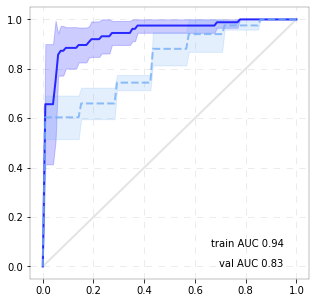

In [28]:
# all suitable metabolites
df_save,_ = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_OEME, title = 'center split ' , modelname = modelname, drift = drift, hyper_param = hyper_param)
df_results = pd.concat([df_results, df_save])

### calculate XGB with data that was not drift corrected

In [29]:
drift = 'drift'

Results for xg and drift for all center split (data without drift correction)
Train Sensitivity:  0.9240506329113924  Specificity:  0.7555555555555555  Accuracy:  0.834319526627219  Balanced Accuracy:  0.839803094233474
Validation Sensitivity:  0.2631578947368421  Specificity:  0.9757281553398058  Accuracy:  0.721875  Balanced Accuracy:  0.6194430250383239
Joint Sensitivity:  0.533678756476684  Specificity:  0.9087837837837838  Accuracy:  0.7607361963190186  Balanced Accuracy:  0.7212312701302339


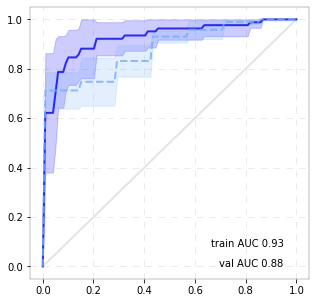

In [30]:
# all suitable metabolites
df_save,_ = test_model(df_train_new, df_val_new, col_OE, title = 'center split '  + no_drift, modelname = modelname, drift = drift, hyper_param = hyper_param)
df_results = pd.concat([df_results, df_save])

## 70:30 balanced split

Results for xg and drift for all 70:30 split (data without drift correction)
Train Sensitivity:  0.9019607843137255  Specificity:  0.7857142857142857  Accuracy:  0.8220858895705522  Balanced Accuracy:  0.8438375350140056
Validation Sensitivity:  0.8256880733944953  Specificity:  0.7095435684647303  Accuracy:  0.7457142857142858  Balanced Accuracy:  0.7676158209296129
Joint Sensitivity:  0.85  Specificity:  0.7337110481586403  Accuracy:  0.769980506822612  Balanced Accuracy:  0.7918555240793201


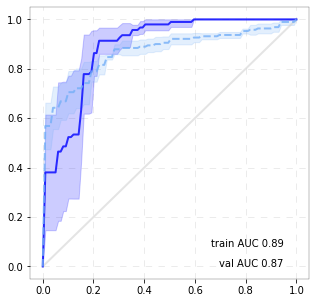

In [31]:
# 70:30 split
df_save, _ = test_model(df_train_new_70, df_val_new_30, col_OE, title='70:30 split '+ no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

### All results of the calculations

In [16]:
df_results

,test_Sensitivity,test_Specificity,test_Accuracy,test_BACC,val_Sensitivity,val_Specificity,val_Accuracy,val_BACC,joint_Sensitivity,joint_Specificity,joint_Accuracy,joint_BACC,# of features,# of samples in trainset,# of samples in valset,test_AUC,val_AUC,joint_AUC
rfdrift correctioncenter split,0.940476,0.811765,0.875740,0.876120,0.216561,0.993865,0.612500,0.605213,0.468880,0.931452,0.703476,0.700166,158,169,64,0.951264,0.822539,0.886901
rfdriftcenter split (data without drift correction),0.945946,0.736842,0.828402,0.841394,0.240385,0.953704,0.721875,0.597044,0.533708,0.887460,0.758691,0.710584,158,169,64,0.948730,0.834943,0.891837
rfdrift70:30 split (data without drift correction),0.866667,0.825243,0.840491,0.845955,0.813333,0.810000,0.811429,0.811667,0.828571,0.815182,0.820663,0.821876,158,163,70,0.920811,0.894758,0.907785
xgdrift correctioncenter split,0.895833,0.876712,0.887574,0.886273,0.192308,1.000000,0.540625,0.596154,0.435252,0.957346,0.660532,0.696299,158,169,64,0.943429,0.825749,0.884589
xgdriftcenter split (data without drift correction),0.924051,0.755556,0.834320,0.839803,0.263158,0.975728,0.721875,0.619443,0.533679,0.908784,0.760736,0.721231,158,169,64,0.925373,0.877352,0.901363
xgdrift70:30 split (data without drift correction),0.901961,0.785714,0.822086,0.843838,0.825688,0.709544,0.745714,0.767616,0.850000,0.733711,0.769981,0.791856,158,163,70,0.888080,0.868368,0.878224


In [17]:
df_results.to_excel('ML_statistics.xlsx')